# Stock Market Prediction using ARIMA and Gradient Boosting Models

## Introduction
This notebook demonstrates the process of predicting stock market prices using ARIMA for time-series analysis and Gradient Boosting for machine learning. It includes data preparation, exploratory data analysis, feature engineering, hyperparameter tuning, and model evaluation.

## Step 1: Data Preparation

### Import Libraries

In [44]:
import pandas as pd
import numpy as np
import yfinance as yf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
import itertools
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

### Download Data

In [20]:
# Download historical stock data for selected equities
tickers = ['AAPL', 'MSFT', 'GOOGL', 'AMZN', 'TSLA']
data = yf.download(tickers, start='2015-01-01', end='2025-01-01', group_by='ticker')

# Save data for one stock (example: AAPL)
stock_data = data['AAPL']
stock_data.reset_index(inplace=True)
stock_data = stock_data[['Date', 'Open', 'High', 'Low', 'Close', 'Volume']]
stock_data.set_index('Date', inplace=True)

# Save to CSV file with the ticker name
csv_filename = "Apple_Data.csv"
stock_data.to_csv(csv_filename, index=False)

[*********************100%***********************]  5 of 5 completed


### Handle Missing Values

In [21]:
stock_data.isnull().sum()

Price
Open      0
High      0
Low       0
Close     0
Volume    0
dtype: int64

In [22]:
# Fill missing values
stock_data = stock_data.fillna(method='ffill')

In [23]:
stock_data.head()

Price,Open,High,Low,Close,Volume
Date,,,,,
2015-01-02,24.778675,24.789798,23.879978,24.320429,212818400
2015-01-05,24.089086,24.169168,23.448431,23.635288,257142000
2015-01-06,23.699794,23.897774,23.274914,23.637508,263188400
2015-01-07,23.846610,24.069060,23.735385,23.968958,160423600
2015-01-08,24.298189,24.947741,24.180289,24.889904,237458000


## Step 2: Exploratory Data Analysis (EDA)

### Description

In [24]:
stock_data.describe()

Price,Open,High,Low,Close,Volume
count,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03
mean,94.092764,95.094510,93.162752,94.179886,1.170867e+08
std,65.584580,66.260520,64.976048,65.665067,6.839957e+07
min,20.596724,20.978908,20.475435,20.674536,2.323470e+07
25%,35.363671,35.742673,34.964034,35.343393,7.105610e+07
50%,64.448193,65.164829,63.803492,64.608196,1.003646e+08
75%,150.569892,152.501759,148.774735,150.747746,1.426216e+08
max,257.906429,259.814335,257.347047,258.735504,6.488252e+08


### Info

In [25]:
stock_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2516 entries, 2015-01-02 to 2024-12-31
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Open    2516 non-null   float64
 1   High    2516 non-null   float64
 2   Low     2516 non-null   float64
 3   Close   2516 non-null   float64
 4   Volume  2516 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 117.9 KB


### Visualize Trends

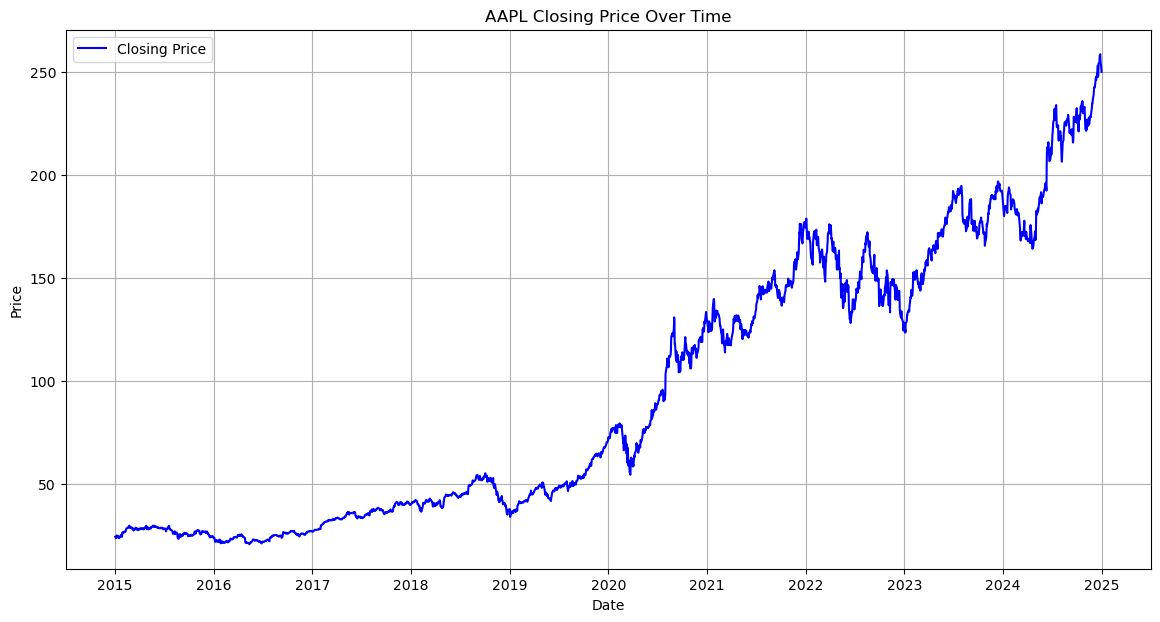

In [26]:
# Plot closing prices
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.title('AAPL Closing Price Over Time')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Moving Averages

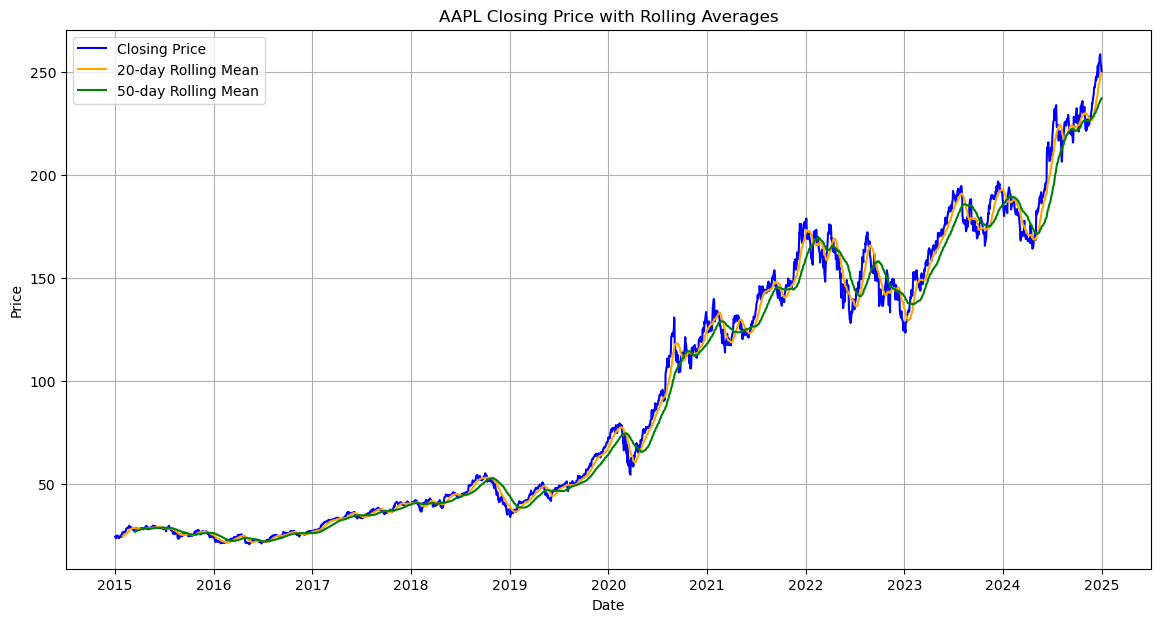

In [27]:
# Add rolling averages for visualization
stock_data['Rolling_Mean_20'] = stock_data['Close'].rolling(window=20).mean()
stock_data['Rolling_Mean_50'] = stock_data['Close'].rolling(window=50).mean()

# Plot closing prices and rolling means
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Closing Price', color='blue')
plt.plot(stock_data['Rolling_Mean_20'], label='20-day Rolling Mean', color='orange')
plt.plot(stock_data['Rolling_Mean_50'], label='50-day Rolling Mean', color='green')
plt.title('AAPL Closing Price with Rolling Averages')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

### Visualize Volume Trends


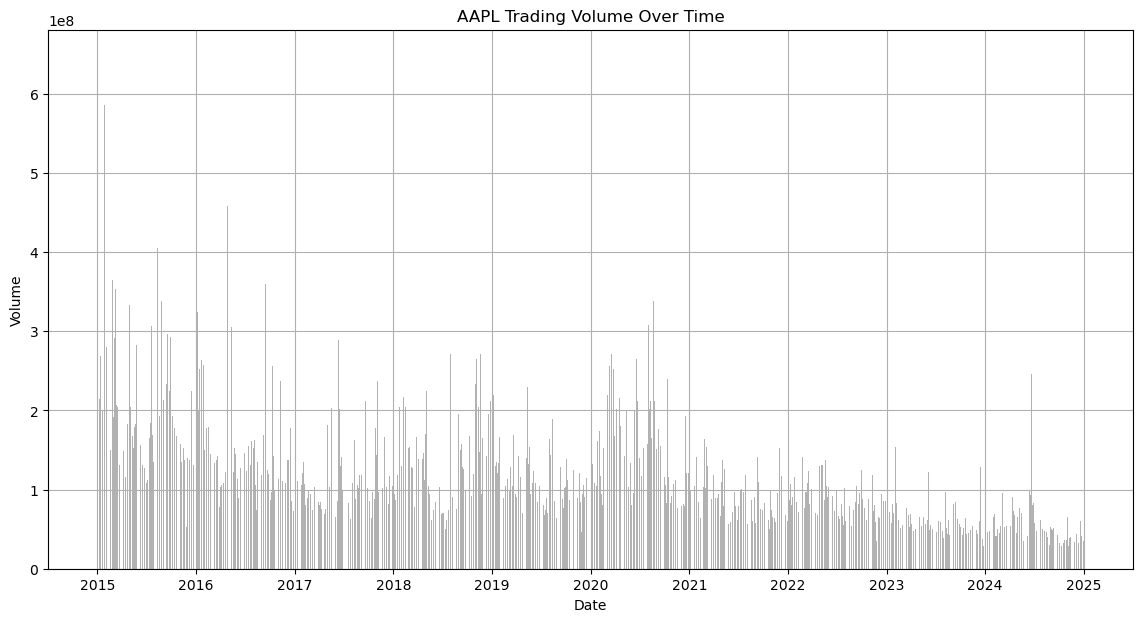

In [28]:
# Plot volume over time to analyze trading activity
plt.figure(figsize=(14, 7))
plt.bar(stock_data.index, stock_data['Volume'], color='gray', alpha=0.6)
plt.title('AAPL Trading Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.grid()
plt.show()

### Correlation

<Axes: xlabel='Price', ylabel='Price'>

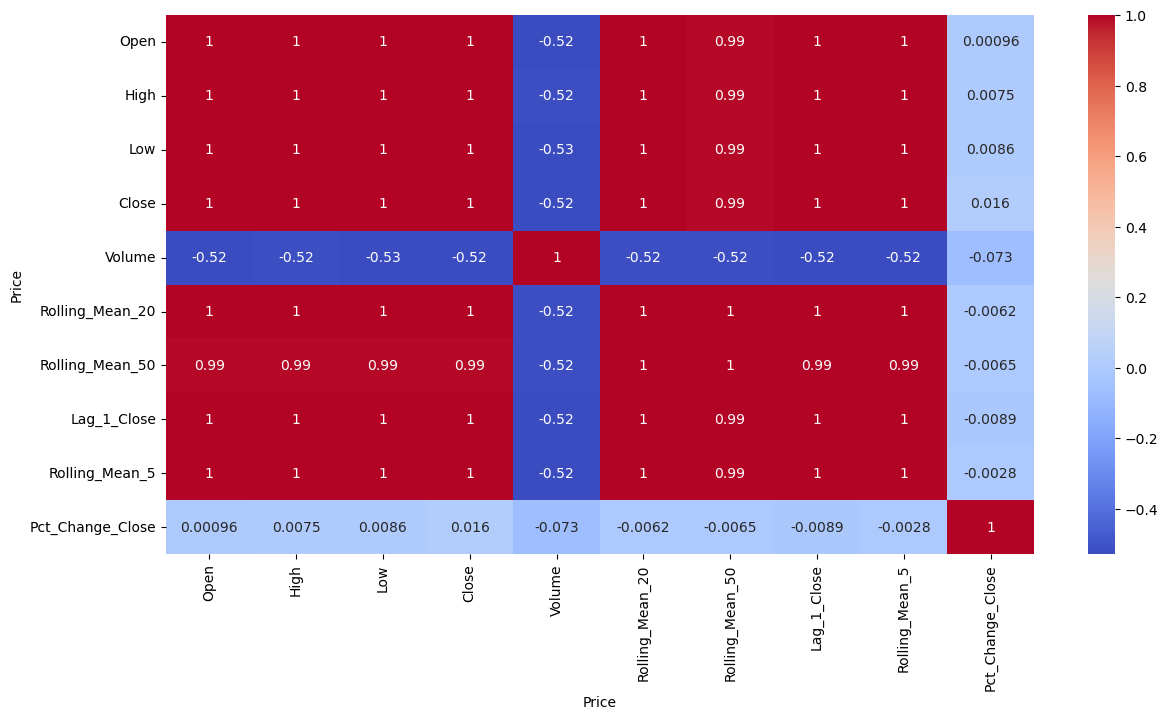

In [64]:
plt.figure(figsize=(14, 7))
sns.heatmap(stock_data.corr(), annot=True, cmap='coolwarm',linecolor='black')

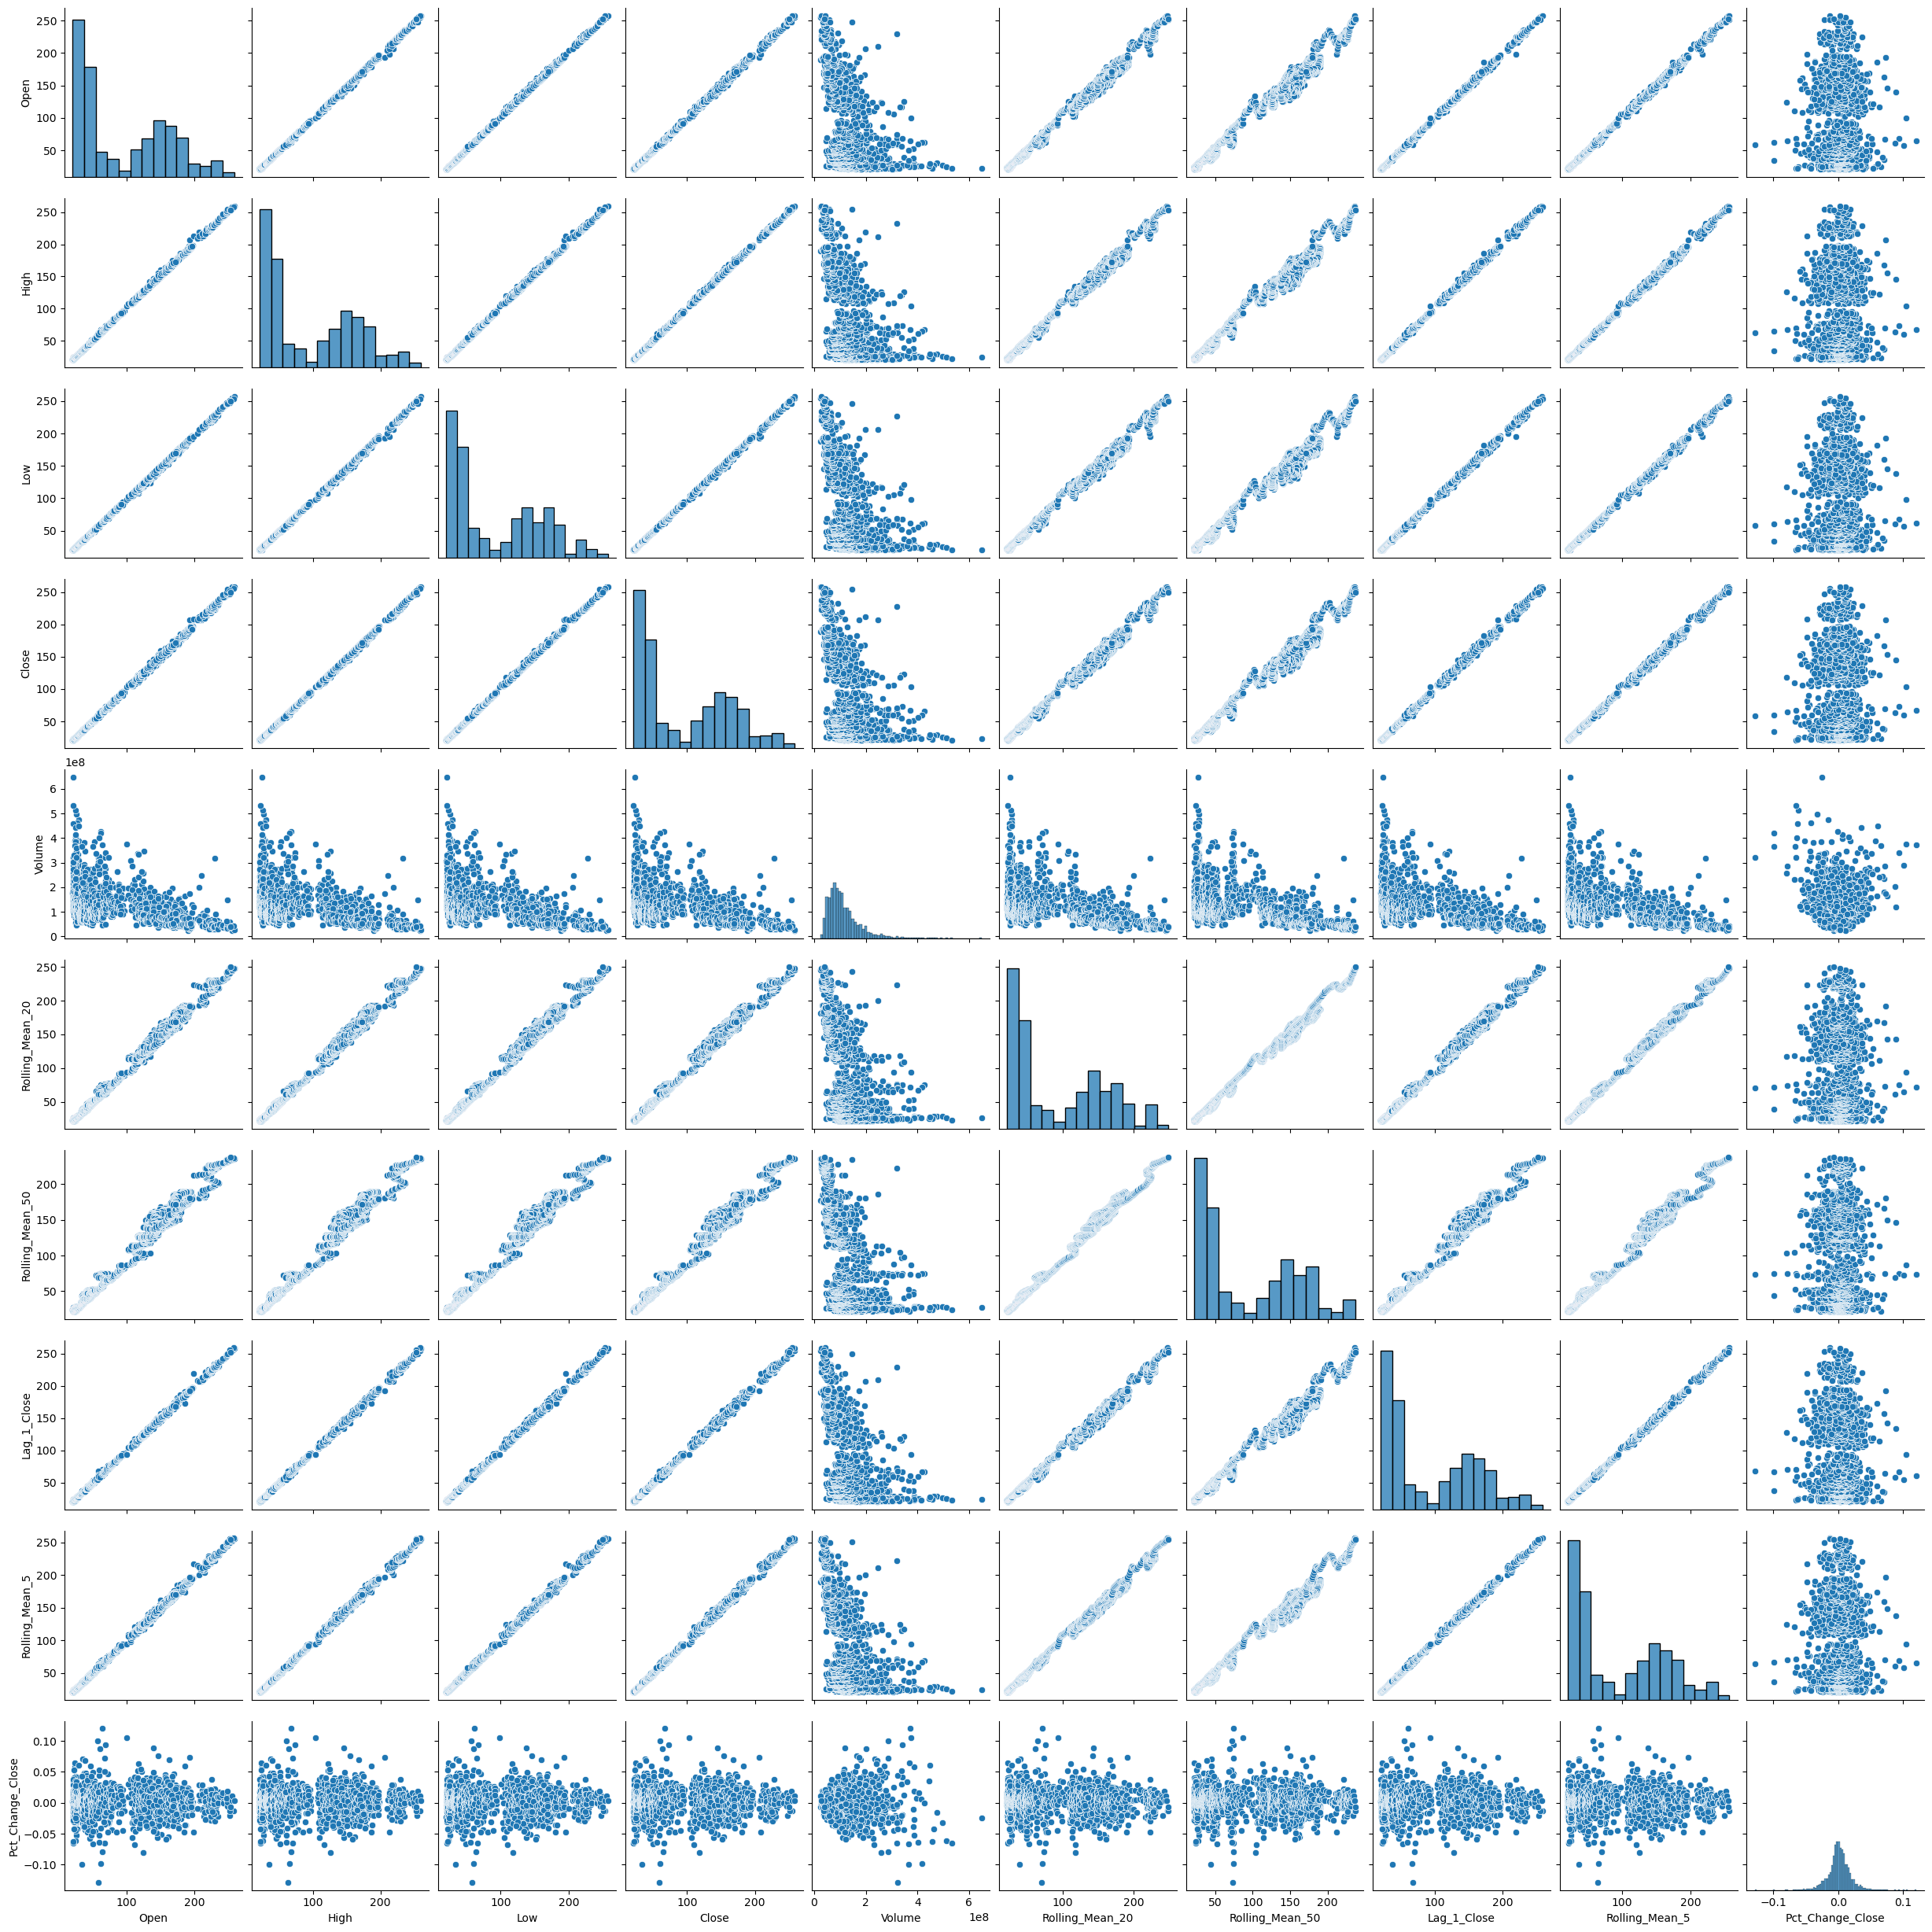

In [61]:
sns.pairplot(stock_data)

## Step 3: Feature Engineering

### Create Features

In [30]:
# Create lagged features for predictive modeling (previous day's closing price)
stock_data['Lag_1_Close'] = stock_data['Close'].shift(1)

# Rolling mean of closing prices (short-term trends)
stock_data['Rolling_Mean_5'] = stock_data['Close'].rolling(window=5).mean()

# Percentage change in closing price (daily returns)
stock_data['Pct_Change_Close'] = stock_data['Close'].pct_change()

# Drop rows with NA values after feature creation
stock_data.dropna(inplace=True)

## Step 4: Modeling

### ARIMA Model with Hyperparameter Tuning

In [ ]:
# Define parameter ranges for ARIMA model tuning
p = range(0, 5)
d = range(0, 2)
q = range(0, 5)
pdq_combinations = list(itertools.product(p, d, q))

best_rmse_arima = float("inf")
best_mae_arima = float("inf")
best_mape_arima = float("inf")
best_pdq = None

# Perform grid search to find optimal ARIMA parameters
for pdq in pdq_combinations:
    try:
        model = ARIMA(stock_data['Close'], order=pdq)
        results = model.fit()
        forecast = results.forecast(steps=10)
        actual = stock_data['Close'].iloc[-10:]  # Last 10 actual values for comparison
        
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        mae = mean_absolute_error(actual, forecast)
        
        if rmse < best_rmse_arima:
            best_rmse_arima = rmse
            best_mae_arima = mae
            best_pdq = pdq
    except:
        continue

print(f"Best Parameters for ARIMA: {best_pdq}")
print(f"Best ARIMA RMSE: {best_rmse_arima}")
print(f"Best ARIMA MAE: {best_mae_arima}")

# Fit final ARIMA model with best parameters
final_arima_model = ARIMA(stock_data['Close'], order=best_pdq).fit()

Best Parameters for ARIMA: (2, 1, 1)
Best ARIMA RMSE: 4.295349428466633
Best ARIMA MAE: 3.588377903454173


In [60]:
# Specify fixed parameters for ARIMA model
p = 2  # Autoregressive order
d = 1  # Degree of differencing
q = 1  # Moving average order

# Fit the ARIMA model with specified parameters
final_arima_model = ARIMA(stock_data['Close'], order=(p, d, q)).fit()

# Forecast using the final model
forecast_final = final_arima_model.forecast(steps=10)
actual_final = stock_data['Close'].iloc[-10:]  # Last 10 actual values for comparison

# Calculate metrics
rmse_final = np.sqrt(mean_squared_error(actual_final, forecast_final))
mae_final = mean_absolute_error(actual_final, forecast_final)
mape_final = np.mean(np.abs((actual_final - forecast_final) / actual_final)) * 100
r2_final = r2_score(actual_final, forecast_final)

# Print metrics
print(f"Fixed Parameters for ARIMA: p={p}, d={d}, q={q}")
print(f"ARIMA RMSE: {rmse_final:.4f}")
print(f"ARIMA MAE: {mae_final:.4f}")

Fixed Parameters for ARIMA: p=2, d=1, q=1
ARIMA RMSE: 4.2953
ARIMA MAE: 3.5884


### Gradient Boosting Model with Hyperparameter Tuning

In [48]:
# Define features and target variable for Gradient Boosting model
features = ['Lag_1_Close', 'Rolling_Mean_5', 'Pct_Change_Close']
X = stock_data[features]
y = stock_data['Close']

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define parameter grid for hyperparameter tuning using GridSearchCV
param_grid = {"learning_rate": [0.1, 0.01],
                "max_depth": [5, 8, 12, 20, 30],
                'min_child_weight': [1, 3, 5],
                'gamma': [0, 0.1, 0.2],
                "subsample": [0.5, 0.8, 1],
                "colsample_bytree": [0.5, 0.8, 1, 0.3, 0.4]}

# Initialize Gradient Boosting model and perform grid search tuning
xgb_model = XGBRegressor(random_state=42)
random_search = RandomizedSearchCV(estimator=xgb_model,
                                   param_distributions=param_grid,
                                   n_iter=100,
                                   scoring='neg_mean_squared_error',
                                   cv=3)
random_search.fit(X_train, y_train)
# Retrieve best model and evaluate performance on test set
best_model = random_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)
# Calculate metrics for the tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test.values, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test.values, y_pred_tuned)
mape_tuned = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100
r2_tuned = r2_score(y_test.values, y_pred_tuned)

# Print results
print("Best Parameters for Gradient Boosting:", random_search.best_params_)
print(f"Tuned Gradient Boosting RMSE: {rmse_tuned:.4f}")
print(f"Tuned Gradient Boosting MAE: {mae_tuned:.4f}")
print(f"Tuned Gradient Boosting MAPE: {mape_tuned:.2f}%")
print(f"Tuned Gradient Boosting R²: {r2_tuned:.4f}")

Best Parameters for Gradient Boosting: {'subsample': 0.5, 'min_child_weight': 3, 'max_depth': 12, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 1}
Tuned Gradient Boosting RMSE: 0.8704
Tuned Gradient Boosting MAE: 0.4626
Tuned Gradient Boosting MAPE: 0.51%
Tuned Gradient Boosting R²: 0.9998


In [47]:
# Initialize Gradient Boosting model with fixed parameters
xgb_model = XGBRegressor(
    learning_rate=0.1,  # Fixed learning rate
    max_depth=8,        # Fixed maximum depth of trees
    min_child_weight=3, # Fixed minimum child weight
    gamma=0.2,          # Fixed gamma value
    subsample=0.5,      # Fixed subsample ratio
    colsample_bytree=1,  # Fixed column sampling ratio
    random_state=42     # Random state for reproducibility
)

# Fit the model on training data
xgb_model.fit(X_train, y_train)

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Calculate metrics for the tuned model
rmse_tuned = np.sqrt(mean_squared_error(y_test.values, y_pred_tuned))
mae_tuned = mean_absolute_error(y_test.values, y_pred_tuned)
mape_tuned = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100
r2_tuned = r2_score(y_test.values, y_pred_tuned)

# Print results
print(f"Gradient Boosting RMSE: {rmse_tuned:.4f}")
print(f"Gradient Boosting MAE: {mae_tuned:.4f}")
print(f"Gradient Boosting MAPE: {mape_tuned:.2f}%")
print(f"Gradient Boosting R²: {r2_tuned:.4f}")

Gradient Boosting RMSE: 0.8840
Gradient Boosting MAE: 0.4933
Gradient Boosting MAPE: 0.56%
Gradient Boosting R²: 0.9998


## Step 5: Model Evaluation

### Evaluation Metrics

In [13]:
# Evaluate ARIMA Model Performance (RMSE, MAE, MAPE)
arima_forecast_test = final_arima_model.forecast(steps=len(y_test))

# RMSE for ARIMA
arima_rmse_test = np.sqrt(mean_squared_error(y_test.values[-len(arima_forecast_test):], arima_forecast_test))

# MAE for ARIMA
arima_mae_test = mean_absolute_error(y_test.values[-len(arima_forecast_test):], arima_forecast_test)

# MAPE for ARIMA
arima_mape_test = np.mean(np.abs((y_test.values[-len(arima_forecast_test):] - arima_forecast_test) / y_test.values[-len(arima_forecast_test):])) * 100

print(f"ARIMA Test RMSE: {arima_rmse_test}")
print(f"ARIMA Test MAE: {arima_mae_test}")
print(f"ARIMA Test MAPE: {arima_mape_test}")

# Evaluate Gradient Boosting Model Performance (RMSE, MAE, MAPE)
# RMSE for Gradient Boosting (already calculated elsewhere as rmse_tuned)
gradient_boosting_rmse_test = rmse_tuned

# MAE for Gradient Boosting
gradient_boosting_mae_test = mean_absolute_error(y_test.values, y_pred_tuned)

# MAPE for Gradient Boosting
gradient_boosting_mape_test = np.mean(np.abs((y_test.values - y_pred_tuned) / y_test.values)) * 100

print(f"Gradient Boosting Test RMSE: {gradient_boosting_rmse_test}")
print(f"Gradient Boosting Test MAE: {gradient_boosting_mae_test}")
print(f"Gradient Boosting Test MAPE: {gradient_boosting_mape_test}")

# Compare Results
print("\nComparison of Model Performance:")
print(f"ARIMA RMSE: {arima_rmse_test}, Gradient Boosting RMSE: {gradient_boosting_rmse_test}")
print(f"ARIMA MAE: {arima_mae_test}, Gradient Boosting MAE: {gradient_boosting_mae_test}")
print(f"ARIMA MAPE: {arima_mape_test:.2f}%, Gradient Boosting MAPE: {gradient_boosting_mape_test:.2f}%")

print('\n')
# Decision Making Based on Metrics
if arima_rmse_test < gradient_boosting_rmse_test:
    print("ARIMA performs better in terms of RMSE.")
else:
    print("Gradient Boosting performs better in terms of RMSE.")

if arima_mae_test < gradient_boosting_mae_test:
    print("ARIMA performs better in terms of MAE.")
else:
    print("Gradient Boosting performs better in terms of MAE.")

if arima_mape_test < gradient_boosting_mape_test:
    print("ARIMA performs better in terms of MAPE.")
else:
    print("Gradient Boosting performs better in terms of MAPE.")

ARIMA Test RMSE: 189.20017552099006
ARIMA Test MAE: 177.6450425993307
ARIMA Test MAPE: 401.5737647309684
Gradient Boosting Test RMSE: 1.0228944632544252
Gradient Boosting Test MAE: 0.6012969924370769
Gradient Boosting Test MAPE: 0.6374052633443874

Comparison of Model Performance:
ARIMA RMSE: 189.20017552099006, Gradient Boosting RMSE: 1.0228944632544252
ARIMA MAE: 177.6450425993307, Gradient Boosting MAE: 0.6012969924370769
ARIMA MAPE: 401.57%, Gradient Boosting MAPE: 0.64%


Gradient Boosting performs better in terms of RMSE.
Gradient Boosting performs better in terms of MAE.
Gradient Boosting performs better in terms of MAPE.


### Visualize Predictions vs Actual Prices for Both Models

* #### Plotting Actual vs ARIMA Forecasts 

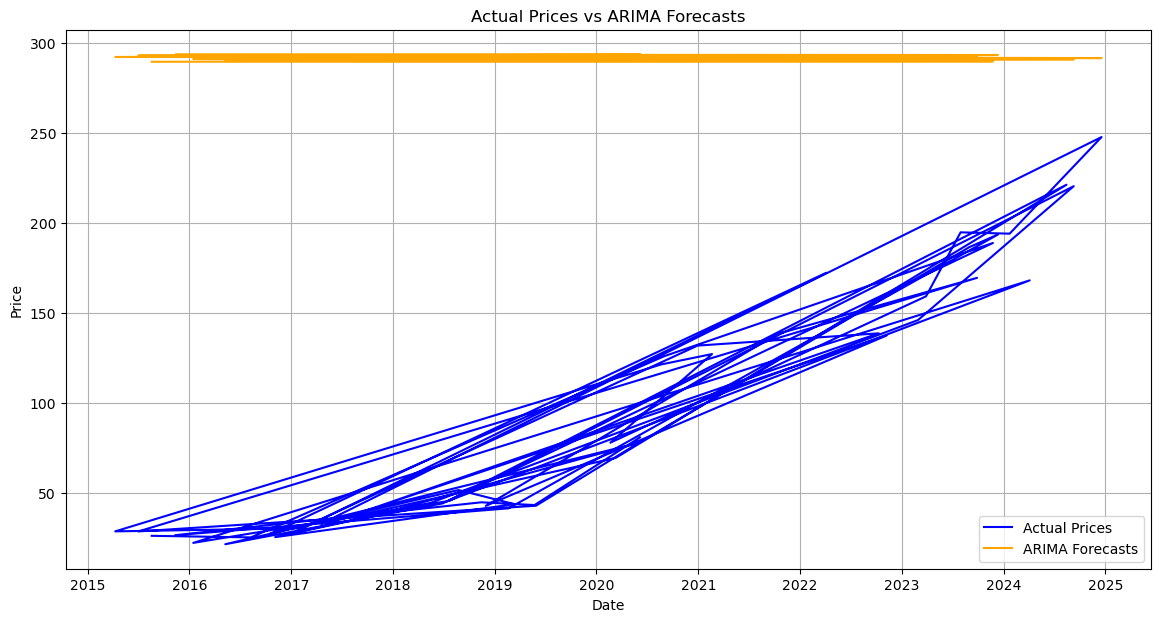

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-50:], y_test.values[-50:], label='Actual Prices', color='blue')
plt.plot(y_test.index[-50:], arima_forecast_test[-50:], label='ARIMA Forecasts', color='orange')
plt.title('Actual Prices vs ARIMA Forecasts')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

* #### Plotting Actual vs Gradient Boosting Predictions

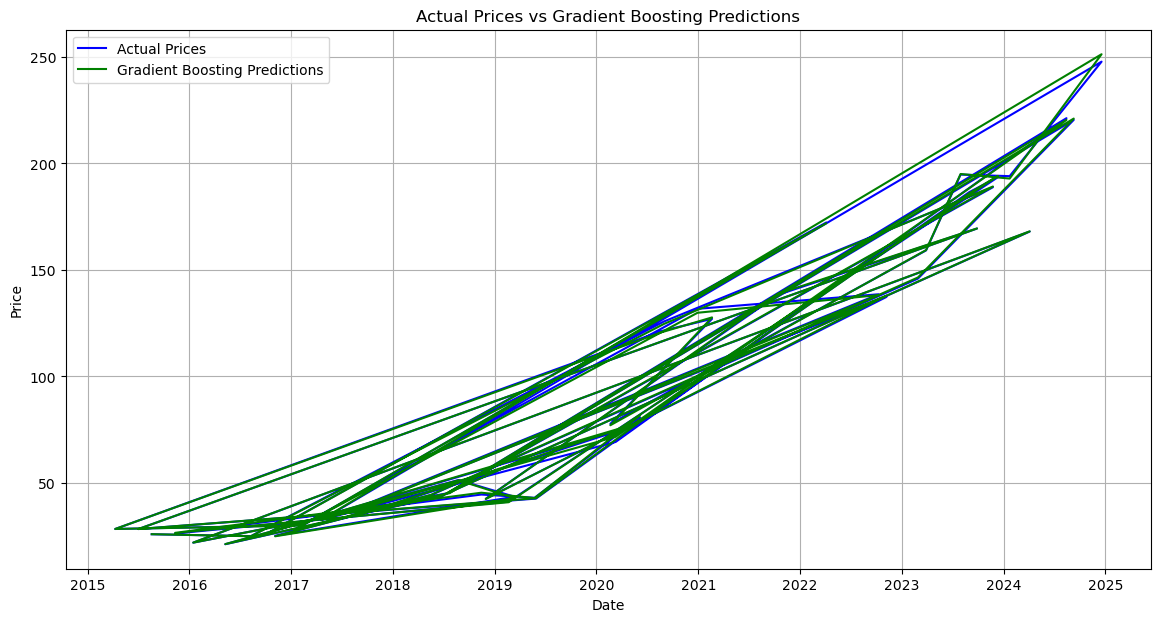

<Figure size 640x480 with 0 Axes>

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(y_test.index[-50:], y_test.values[-50:], label='Actual Prices', color='blue')
plt.plot(y_test.index[-50:], y_pred_tuned[-50:], label='Gradient Boosting Predictions', color='green')
plt.title('Actual Prices vs Gradient Boosting Predictions')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid()
plt.show()

## Step 6: Conclusions and Recommendations
* ARIMA Model: Suitable for time-dependent patterns and short-term trend predictions.

* Gradient Boosting Model: Performs well with engineered features, handling sudden fluctuations effectively.

#### Recommendations:

* Combine both models for hybrid predictions.

* Use ARIMA for stable trends and Gradient Boosting for capturing non-linear relationships.